# Chlamydia in England, 2000-2015: dynamic analysis

Our analysis of chlamydia prevalence estimates between 2000 and 2015 assumes a system is in a steady state. This workbook investigates this assumption in more detail by perturbing the system and observing the return to equilibrium.

## Data
Begin by reading in the data:

In [1]:
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

population_f = pd.read_csv('data/population_f.csv', index_col=0)
population_m = pd.read_csv('data/population_m.csv', index_col=0)

tests_f_max = pd.read_csv('data/tests_f_max.csv', index_col=0)
tests_f_min = pd.read_csv('data/tests_f_min.csv', index_col=0)
tests_m_max = pd.read_csv('data/tests_m_max.csv', index_col=0)
tests_m_min = pd.read_csv('data/tests_m_min.csv', index_col=0)

diagnoses_f_max = pd.read_csv('data/diagnoses_f_max.csv', index_col=0)
diagnoses_f_min = pd.read_csv('data/diagnoses_f_min.csv', index_col=0)
diagnoses_m_max = pd.read_csv('data/diagnoses_m_max.csv', index_col=0)
diagnoses_m_min = pd.read_csv('data/diagnoses_m_min.csv', index_col=0)

## Calculating chlamydia prevalence

We now estimate year-on-year changes in chlamydia prevalence, using the method described in Lewis and White Epidemiology 28:492-502 (2017) and at https://github.com/joanna-lewis/ct_surveillance.

Sample testing and diagnosis rates, based on the data.

In [2]:
from scipy.stats import beta
from scipy.stats import gamma

import numpy as np
from numpy import *
from numpy.random import normal

rs = random.RandomState(12345)

n_sample = 10000

# proportion sexually active

p_active_f = empty([1,4,n_sample])
p_active_m = empty([1,4,n_sample])

# Beta parameters from analysis in R
p_active_f[0,0,:] = rs.beta(313.4784, 146.67142, size=n_sample) # 16-19
p_active_f[0,1,:] = rs.beta(694.6619, 37.21263, size=n_sample) # 20-24
p_active_f[0,2,:] = rs.beta(3052.6887, 22.20244, size=n_sample) # 25-34
p_active_f[0,3,:] = rs.beta(2261.2593, 19.68334, size=n_sample) # 35-44

p_active_m[0,0,:] = rs.beta(265.5745, 141.82596, size=n_sample) # 16-19
p_active_m[0,1,:] = rs.beta(552.6503, 38.68801, size=n_sample) # 20-24
p_active_m[0,2,:] = rs.beta(1629.9402, 58.42669, size=n_sample) # 25-34
p_active_m[0,3,:] = rs.beta(2023.0315, 36.71242, size=n_sample) # 35-44

# population sexually active

pop_active_f = empty([16,4,n_sample])
pop_active_m = empty([16,4,n_sample])

for i in xrange(16):
    for j in xrange(4):

        pop_active_f[i,j,:] = rs.binomial(
            int(pd.DataFrame.as_matrix(population_f)[i,j]), p_active_f[0,j,:], size=n_sample)
        
        pop_active_m[i,j,:] = rs.binomial(
            int(pd.DataFrame.as_matrix(population_m)[i,j]), p_active_m[0,j,:], size=n_sample)

Next, sample from distributions for the probability of being sexually active, the size of the sexually active population and the testing and diagnosis rates per person per year.

In [3]:
# testing and diagnosis rates, per person per year

test_rate_f_max = empty([16,4,n_sample])
test_rate_f_min = empty([16,4,n_sample])
test_rate_m_max = empty([16,4,n_sample])
test_rate_m_min = empty([16,4,n_sample])

diag_rate_f_max = empty([16,4,n_sample])
diag_rate_f_min = empty([16,4,n_sample])
diag_rate_m_max = empty([16,4,n_sample])
diag_rate_m_min = empty([16,4,n_sample])

for i in xrange(16):
    for j in xrange(4):

        test_rate_f_max[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(tests_f_max)[i,j]*pd.DataFrame.as_matrix(population_f)[i,j]/100., 1, size=n_sample)/ \
            pop_active_f[i,j]
        test_rate_f_min[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(tests_f_min)[i,j]*pd.DataFrame.as_matrix(population_f)[i,j]/100., 1, size=n_sample)/ \
            pop_active_f[i,j]
        test_rate_m_max[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(tests_m_max)[i,j]*pd.DataFrame.as_matrix(population_m)[i,j]/100., 1, size=n_sample)/ \
            pop_active_m[i,j]
        test_rate_m_min[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(tests_m_min)[i,j]*pd.DataFrame.as_matrix(population_m)[i,j]/100., 1, size=n_sample)/ \
            pop_active_m[i,j]

        diag_rate_f_max[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(diagnoses_f_max)[i,j]*pd.DataFrame.as_matrix(population_f)[i,j]/100000., 1, size=n_sample)/ \
            pop_active_f[i,j]
        diag_rate_f_min[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(diagnoses_f_min)[i,j]*pd.DataFrame.as_matrix(population_f)[i,j]/100000., 1, size=n_sample)/ \
            pop_active_f[i,j]
        diag_rate_m_max[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(diagnoses_m_max)[i,j]*pd.DataFrame.as_matrix(population_m)[i,j]/100000., 1, size=n_sample)/ \
            pop_active_m[i,j]
        diag_rate_m_min[i,j] = rs.gamma(
            pd.DataFrame.as_matrix(diagnoses_m_min)[i,j]*pd.DataFrame.as_matrix(population_m)[i,j]/100000., 1, size=n_sample)/ \
            pop_active_m[i,j]



In [4]:
# This script contains the functions linking observed tests, symptomatic/asymptomatic/toal diagnoses, 
# incidence, prevalence, screening and other model parameters
# Running it takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

# This script provides a function for calculating the likelihood of categorical data.
%run -i multinomial_pmf.py

# This script samples model parameters from prior distributions, following the method in england.ipynb.
%run -i sample_parameters.py

In [5]:
# The sampled parameter values are now used to infer prevalence in men and women in different age groups, each year.
# max and min refer to the numbers of tests and diagnoses

prev_f_min = empty([16,4,n_sample])
inc_f_min = empty([16,4,n_sample])
scr_f_min = empty([16,4,n_sample])

prev_f_max = empty([16,4,n_sample])
inc_f_max = empty([16,4,n_sample])
scr_f_max = empty([16,4,n_sample])

prev_m_min = empty([16,4,n_sample])
inc_m_min = empty([16,4,n_sample])
scr_m_min = empty([16,4,n_sample])

prev_m_max = empty([16,4,n_sample])
inc_m_max = empty([16,4,n_sample])
scr_m_max = empty([16,4,n_sample])

for i in xrange(16):
    print 'i = ', i
    for j in xrange(4):
#        print 'j = ', j
        for k in xrange(n_sample):
            
            # prevalence in women (minimum tests and diagnoses)
            [inc_f_min[i,j,k], scr_f_min[i,j,k]] = fsolve(lambda x: test_diag_fun(concatenate([
                            x, array([
                                    1-p_asymp_f[k], # proportion of incident infections which are symptomatic
                                    sc_f[k], # rate of self-clear 
                                    att_symp[k],
                                    p_true_pos_f[k], 
                                    p_false_pos_f[k]
                                ])])) - array([test_rate_f_min[i,j,k],diag_rate_f_min[i,j,k]]), [0.09, 0.25])
            prev_f_min[i,j,k] = dyn_fun(
                inc_f_min[i,j,k]*p_asymp_f[k], 
                sc_f[k] + scr_f_min[i,j,k]*p_true_pos_f[k], 
                inc_f_min[i,j,k]*(1-p_asymp_f[k]), 
                scr_f_min[i,j,k]*p_true_pos_f[k] + att_symp[k]*p_true_pos_f[k]
                )
            
            # maximum prevalence in women (maximum tests and diagnoses)
            [inc_f_max[i,j,k], scr_f_max[i,j,k]] = fsolve(lambda x: test_diag_fun(concatenate([
                            x, array([
                                    1-p_asymp_f[k], # proportion of incident infections which are symptomatic
                                    sc_f[k], # rate of self-clear 
                                    att_symp[k],
                                    p_true_pos_f[k], 
                                    p_false_pos_f[k]
                                ])])) - array([test_rate_f_max[i,j,k],diag_rate_f_max[i,j,k]]), [0.09, 0.25])
            prev_f_max[i,j,k] = dyn_fun(
                inc_f_max[i,j,k]*p_asymp_f[k], 
                sc_f[k] + scr_f_max[i,j,k]*p_true_pos_f[k], 
                inc_f_max[i,j,k]*(1-p_asymp_f[k]), 
                scr_f_max[i,j,k]*p_true_pos_f[k] + att_symp[k]*p_true_pos_f[k]
                )
            
            # prevalence in men (minimum tests and diagnoses)
            [inc_m_min[i,j,k], scr_m_min[i,j,k]] = fsolve(lambda x: test_diag_fun(concatenate([
                            x, array([
                                    1-p_asymp_m[k], # proportion of incident infections which are symptomatic
                                    sc_m[k], # rate of self-clear 
                                    att_symp[k],
                                    p_true_pos_m[k], 
                                    p_false_pos_m[k]
                                ])])) - array([test_rate_m_min[i,j,k],diag_rate_m_min[i,j,k]]), [0.09, 0.25])
            prev_m_min[i,j,k] = dyn_fun(
                inc_m_min[i,j,k]*p_asymp_m[k], 
                sc_m[k] + scr_m_min[i,j,k]*p_true_pos_m[k], 
                inc_m_min[i,j,k]*(1-p_asymp_m[k]), 
                scr_m_min[i,j,k]*p_true_pos_m[k] + att_symp[k]*p_true_pos_m[k]
                )

            # prevalence in men (maximum tests and diagnoses)
            [inc_m_max[i,j,k], scr_m_max[i,j,k]] = fsolve(lambda x: test_diag_fun(concatenate([
                            x, array([
                                    1-p_asymp_m[k], # proportion of incident infections which are symptomatic
                                    sc_m[k], # rate of self-clear 
                                    att_symp[k],
                                    p_true_pos_m[k], 
                                    p_false_pos_m[k]
                                ])])) - array([test_rate_m_max[i,j,k],diag_rate_m_max[i,j,k]]), [0.09, 0.25])
            prev_m_max[i,j,k] = dyn_fun(
                inc_m_max[i,j,k]*p_asymp_m[k], 
                sc_m[k] + scr_m_max[i,j,k]*p_true_pos_m[k], 
                inc_m_max[i,j,k]*(1-p_asymp_m[k]), 
                scr_m_max[i,j,k]*p_true_pos_m[k] + att_symp[k]*p_true_pos_m[k]
                )
    
print 'Finished.'

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
Finished.


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Simulate year-to-year dynamics

Now set up a function to simulate year-to-year dynamics:

In [6]:
from scipy.optimize import fsolve

tsym, dsym, ssym, test_sym, p_true_pos, p_false_pos = symbols('tsym dsym ssym test_sym p_true_pos p_false_pos')

model_test_diag = [
    tsym - ( ssym + (1 - A - U)*test_sym ),
    dsym - ( A*ssym*p_true_pos + U*ssym*p_false_pos + (1 - A - U)*test_sym*p_true_pos )
    ]

sol_test_diag = solve(model_test_diag, tsym, dsym)
test_fun = lambdify((A, U, ssym, test_sym), sol_test_diag[tsym])
diag_fun = lambdify((A, U, ssym, test_sym), sol_test_diag[dsym])

def test_diag_fun(parms):
    # parms = (incidence, screening rate)
    inc = parms[0]
    scr = parms[1]
    
    A = A_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1 - p_asymp), scr*p_true_pos + att_symp*p_true_pos)
    U = U_fun(inc*p_asymp, sc + scr*p_true_pos, inc*(1 - p_asymp), scr*p_true_pos + att_symp*p_true_pos)
    return [test_fun(A, U, scr, att_symp), diag_fun(A, U, scr, att_symp)]


# set up a function to simulate system dynamics when perturbed from steady state
from scipy.integrate import odeint

def dydt(y, t, parms):
    # y = (U, A, S)
    return([
    parms[1]*y[1] + parms[3]*y[2] - (parms[0] + parms[2])*y[0],
    parms[0]*y[0] - parms[1]*y[1],
    parms[2]*y[0] - parms[3]*y[2]
    ])

Taking minimum and maximum figures for men and women in turn, the analysis proceeds as follows:

1. Begin by estimating the steady state in 2000, using 2000 data.
2. Assuming a (potentially different) steady state in 2001, estimate incidence and screening rate in 2001.
3. Starting at the 2000 steady state, simulate the evolution of the system for one year with 2001 incidence and screening figures. 
4. Repeat steps 2 and 3 for subsequent years, each time starting the system in the state it had reached at the end of the previous one-year period.

The results of the simulations are then plotted.


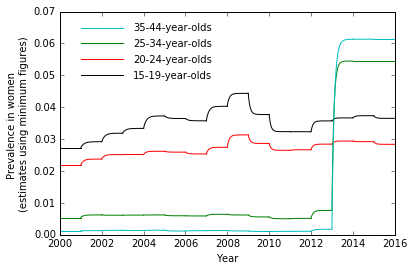

In [7]:
# minimum figures; women

%matplotlib inline
import matplotlib.pyplot as plt

cols=['k','r','g','c']

for j in xrange(4):
    
    ind = argmin(np.abs(np.median(prev_f_min[0,j,:]) - prev_f_min[0,j,:]))
    
    U_2000 = U_fun(
        inc_f_min[0,j,ind]*p_asymp_f[ind], 
        sc_f[ind] + scr_f_min[0,j,ind]*p_true_pos_f[ind], 
        inc_f_min[0,j,ind]*(1-p_asymp_f[ind]), 
        scr_f_min[0,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]
        )
    
    A_2000 = A_fun(
        inc_f_min[0,j,ind]*p_asymp_f[ind], 
        sc_f[ind] + scr_f_min[0,j,ind]*p_true_pos_f[ind], 
        inc_f_min[0,j,ind]*(1-p_asymp_f[ind]), 
        scr_f_min[0,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]
        )
    
    S_2000 = S_fun(
        inc_f_min[0,j,ind]*p_asymp_f[ind], 
        sc_f[ind] + scr_f_min[0,j,ind]*p_true_pos_f[ind], 
        inc_f_min[0,j,ind]*(1-p_asymp_f[ind]), 
        scr_f_min[0,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]
        )
    
    sol = empty([1000,3])
    sol[999,0] = U_2000
    sol[999,1] = A_2000
    sol[999,2] = S_2000    
    
    plt.plot([2001,2003],[0.05+j*0.005, 0.05+j*0.005], cols[j])
    
    for i in xrange(16):
    
        # parameters
        parms = [inc_f_min[i,j,ind]*p_asymp_f[ind], 
                 sc_f[ind] + scr_f_min[i,j,ind]*p_true_pos_f[ind], 
                 inc_f_min[i,j,ind]*(1-p_asymp_f[ind]), 
                 scr_f_min[i,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]]
    
        # solve
        sol = odeint(dydt, 
               sol[999,:], 
               linspace(0,10,1000), 
               args = (parms,)
              )

        # plot
        plt.plot(2000 + i + linspace(0,1,1000), 
                 sol[:,1] + sol[:,2],
                 cols[j]
                )

plt.xlabel('Year')
plt.ylabel('Prevalence in women \n(estimates using minimum figures)')
        
plt.text(2003.5, 0.05, '15-19-year-olds', va='center')
plt.text(2003.5, 0.055, '20-24-year-olds', va='center')
plt.text(2003.5, 0.06, '25-34-year-olds', va='center')
plt.text(2003.5, 0.065, '35-44-year-olds', va='center')
    
#plt.xlim([2009,2013])
#plt.ylim([0,0.001])

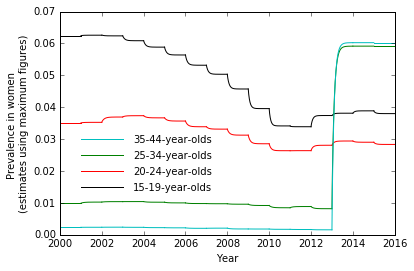

In [8]:
# maximum figures; women
for j in xrange(4):
    
    ind = argmin(np.abs(np.median(prev_f_max[0,j,:]) - prev_f_max[0,j,:]))
    
    U_2000 = U_fun(
        inc_f_max[0,j,ind]*p_asymp_f[ind], 
        sc_f[ind] + scr_f_max[0,j,ind]*p_true_pos_f[ind], 
        inc_f_max[0,j,ind]*(1-p_asymp_f[ind]), 
        scr_f_max[0,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]
        )
    
    A_2000 = A_fun(
        inc_f_max[0,j,ind]*p_asymp_f[ind], 
        sc_f[ind] + scr_f_max[0,j,ind]*p_true_pos_f[ind], 
        inc_f_max[0,j,ind]*(1-p_asymp_f[ind]), 
        scr_f_max[0,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]
        )
    
    S_2000 = S_fun(
        inc_f_max[0,j,ind]*p_asymp_f[ind], 
        sc_f[ind] + scr_f_max[0,j,ind]*p_true_pos_f[ind], 
        inc_f_max[0,j,ind]*(1-p_asymp_f[ind]), 
        scr_f_max[0,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]
        )
    
    sol = empty([1000,3])
    sol[999,0] = U_2000
    sol[999,1] = A_2000
    sol[999,2] = S_2000    
    
    plt.plot([2001,2003],[0.015+j*0.005, 0.015+j*0.005], cols[j])

    for i in xrange(16):
    
        # parameters
        parms = [inc_f_max[i,j,ind]*p_asymp_f[ind], 
                 sc_f[ind] + scr_f_max[i,j,ind]*p_true_pos_f[ind], 
                 inc_f_max[i,j,ind]*(1-p_asymp_f[ind]), 
                 scr_f_max[i,j,ind]*p_true_pos_f[ind] + att_symp[ind]*p_true_pos_f[ind]]
    
        # solve
        sol = odeint(dydt, 
               sol[999,:], 
               linspace(0,10,1000), 
               args = (parms,)
              )

        # plot
        plt.plot(2000 + i + linspace(0,1,1000), 
                 sol[:,1] + sol[:,2],
                 cols[j]
                )
        
plt.xlabel('Year')
plt.ylabel('Prevalence in women \n(estimates using maximum figures)')
        
plt.text(2003.5, 0.015, '15-19-year-olds', va='center')
plt.text(2003.5, 0.02, '20-24-year-olds', va='center')
plt.text(2003.5, 0.025, '25-34-year-olds', va='center')
plt.text(2003.5, 0.03, '35-44-year-olds', va='center')
    
#plt.xlim([2009,2013])
#plt.ylim([0,0.001])

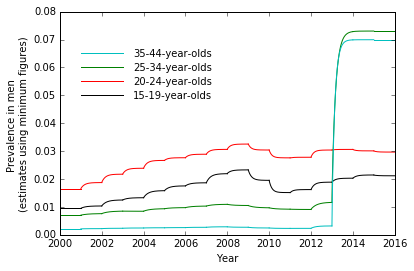

In [9]:
# minimum figures; men
for j in xrange(4):
    
    ind = argmin(np.abs(np.median(prev_m_min[0,j,:]) - prev_m_min[0,j,:]))
    
    U_2000 = U_fun(
        inc_m_min[0,j,ind]*p_asymp_m[ind], 
        sc_m[ind] + scr_m_min[0,j,ind]*p_true_pos_m[ind], 
        inc_m_min[0,j,ind]*(1-p_asymp_m[ind]), 
        scr_m_min[0,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]
        )
    
    A_2000 = A_fun(
        inc_m_min[0,j,ind]*p_asymp_m[ind], 
        sc_m[ind] + scr_m_min[0,j,ind]*p_true_pos_m[ind], 
        inc_m_min[0,j,ind]*(1-p_asymp_m[ind]), 
        scr_m_min[0,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]
        )
    
    S_2000 = S_fun(
        inc_m_min[0,j,ind]*p_asymp_m[ind], 
        sc_m[ind] + scr_m_min[0,j,ind]*p_true_pos_m[ind], 
        inc_m_min[0,j,ind]*(1-p_asymp_m[ind]), 
        scr_m_min[0,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]
        )
    
    sol = empty([1000,3])
    sol[999,0] = U_2000
    sol[999,1] = A_2000
    sol[999,2] = S_2000    
    
    plt.plot([2001,2003],[0.05+j*0.005, 0.05+j*0.005], cols[j])

    for i in xrange(16):
    
        # parameters
        parms = [inc_m_min[i,j,ind]*p_asymp_m[ind], 
                 sc_m[ind] + scr_m_min[i,j,ind]*p_true_pos_m[ind], 
                 inc_m_min[i,j,ind]*(1-p_asymp_m[ind]), 
                 scr_m_min[i,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]]
    
        # solve
        sol = odeint(dydt, 
               sol[999,:], 
               linspace(0,10,1000), 
               args = (parms,)
              )

        # plot
        plt.plot(2000 + i + linspace(0,1,1000), 
                 sol[:,1] + sol[:,2],
                 cols[j]
                )
        
plt.xlabel('Year')
plt.ylabel('Prevalence in men \n(estimates using minimum figures)')
        
plt.text(2003.5, 0.05, '15-19-year-olds', va='center')
plt.text(2003.5, 0.055, '20-24-year-olds', va='center')
plt.text(2003.5, 0.06, '25-34-year-olds', va='center')
plt.text(2003.5, 0.065, '35-44-year-olds', va='center')
        
#plt.xlim([2009,2013])
#plt.ylim([0,0.001])

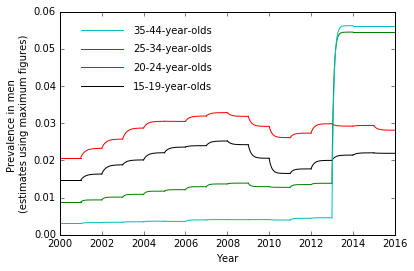

In [10]:
# maximum figures; men

%matplotlib inline
import matplotlib.pyplot as plt

cols=['k','r','g','c']

for j in xrange(4):
    
    ind = argmin(np.abs(np.median(prev_m_max[0,j,:]) - prev_m_max[0,j,:]))
    
    U_2000 = U_fun(
        inc_m_max[0,j,ind]*p_asymp_m[ind], 
        sc_m[ind] + scr_m_max[0,j,ind]*p_true_pos_m[ind], 
        inc_m_max[0,j,ind]*(1-p_asymp_m[ind]), 
        scr_m_max[0,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]
        )
    
    A_2000 = A_fun(
        inc_m_max[0,j,ind]*p_asymp_m[ind], 
        sc_m[ind] + scr_m_max[0,j,ind]*p_true_pos_m[ind], 
        inc_m_max[0,j,ind]*(1-p_asymp_m[ind]), 
        scr_m_max[0,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]
        )
    
    S_2000 = S_fun(
        inc_m_max[0,j,ind]*p_asymp_m[ind], 
        sc_m[ind] + scr_m_max[0,j,ind]*p_true_pos_m[ind], 
        inc_m_max[0,j,ind]*(1-p_asymp_m[ind]), 
        scr_m_max[0,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]
        )
    
    sol = empty([1000,3])
    sol[999,0] = U_2000
    sol[999,1] = A_2000
    sol[999,2] = S_2000    
    
    plt.plot([2001,2003],[0.04+j*0.005, 0.04+j*0.005], cols[j])

    for i in xrange(16):
    
        # parameters
        parms = [inc_m_max[i,j,ind]*p_asymp_m[ind], 
                 sc_m[ind] + scr_m_max[i,j,ind]*p_true_pos_m[ind], 
                 inc_m_max[i,j,ind]*(1-p_asymp_m[ind]), 
                 scr_m_max[i,j,ind]*p_true_pos_m[ind] + att_symp[ind]*p_true_pos_m[ind]]
    
        # solve
        sol = odeint(dydt, 
               sol[999,:], 
               linspace(0,10,1000), 
               args = (parms,)
              )

        # plot
        plt.plot(2000 + i + linspace(0,1,1000), 
                 sol[:,1] + sol[:,2],
                 cols[j]
                )
        
plt.xlabel('Year')
plt.ylabel('Prevalence in men \n(estimates using maximum figures)')
        
plt.text(2003.5, 0.04, '15-19-year-olds', va='center')
plt.text(2003.5, 0.045, '20-24-year-olds', va='center')
plt.text(2003.5, 0.05, '25-34-year-olds', va='center')
plt.text(2003.5, 0.055, '35-44-year-olds', va='center')
                
#plt.xlim([2009,2013])
#plt.ylim([0,0.001])

We find that in all age/sex groups, the dynamics of the system are fast compared to the timescale of the data and the steady-state approximation is appropriate.